# LAB 3: Frequency filtering 

## Declaration and import of the `p3.py` file

Imports:

In [29]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from PIL import Image
from scipy.ndimage import filters
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import math as math
import glob
import os
import sys

sys.path.append("../../p1/code") # set the path for visualPercepUtils.py
import visualPercepUtils as vpu


Methods_

In [30]:
# ----------------------
# Fourier Transform
# ----------------------

def FT(im):
    # https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html
    return fft.fftshift(fft.fft2(im))  # perform also the shift to have lower frequencies at the center


def IFT(ft):
    return fft.ifft2(fft.ifftshift(ft))  # assumes ft is shifted and therefore reverses the shift before IFT


def testFT(im, params=None):
    ft = FT(im)
    #print(ft.shape)
    phase = np.angle(ft)
    magnitude = np.log(np.absolute(ft))
    bMagnitude = True
    if bMagnitude:
        im2 = np.absolute(IFT(ft))  # IFT consists of complex number. When applied to real-valued data the imaginary part should be zero, but not exactly for numerical precision issues
    else:
        im2 = np.real(IFT(ft)) # with just the module we can't appreciate the effect of a shift in the signal (e.g. if we use fftshift but not ifftshift, or viceversa)
        # Important: one case where np.real() is appropriate but np.absolute() is not is where the sign in the output is relevant
    return [magnitude, phase, im2]


# -----------------------
# Convolution theorem
# -----------------------

# the mask corresponding to the average (mean) filter
def avgFilter(filterSize):
    mask = np.ones((filterSize, filterSize))
    return mask/np.sum(mask)


# apply average filter in the spatial domain
def averageFilterSpace(im, filterSize):
    return filters.convolve(im, avgFilter(filterSize))


# apply average filter in the frequency domain
def averageFilterFrequency(im, filterSize):
    filterMask = avgFilter(filterSize)  # the usually small mask
    filterBig = np.zeros_like(im, dtype=float)  # as large as the image (dtype is important here!)

    # Now, place filter (the "small" filter mask) at the center of the "big" filter

    ## First, get sizes
    w, h = filterMask.shape
    w2, h2 = w / 2, h / 2  # half width and height of the "small" mask
    W, H = filterBig.shape
    W2, H2 = W / 2, H / 2  # half width and height of the "big" mask

    ## Then, paste the small mask at the center using the sizes computed before as an aid
    filterBig[int(W2 - w2):int(W2 + w2), int(H2 - h2):int(H2 + h2)] = filterMask

    # FFT of the big filter
    filterBig = fft.ifftshift(filterBig)  # shift origin at upper-left corner

    # Finally, IFT of the element-wise product of the FT's
    return np.absolute(IFT(FT(im) * FT(filterBig)))  # both '*' and multiply() perform elementwise product


def testConvTheo(im, params=None):
    filterSize = params['filterSize']

    # image filtered with a convolution in spatial domain
    imFiltSpace = averageFilterSpace(im, filterSize)

    # image filtered in frequency domain
    imFiltFreq = averageFilterFrequency(im, filterSize)

    # How much do they differ?
    # To quantify the difference, we use the Root Mean Square Measure (https://en.wikipedia.org/wiki/Root_mean_square)
    margin = 5  # exclude some outer pixels to reduce the influence of border effects
    rms = np.linalg.norm(imFiltSpace[margin:-margin, margin:-margin] - imFiltFreq[margin:-margin, margin:-margin], 2) / np.prod(im.shape)
    print("Images filtered in space and frequency differ in (RMS):", rms)

    return [imFiltSpace, imFiltFreq]


# -----------------------------------
# High-, low- and band-pass filters
# -----------------------------------

# generic band-pass filter (both, R and r, given) which includes the low-pass (r given, R not)
# and the high-pass (R given, r not) as particular cases
def bandPassFilter(shape, r=None, R=None):
    n, m = shape
    m2, n2 = np.floor(m / 2.0), np.floor(n / 2.0)
    [vx, vy] = np.meshgrid(np.arange(-m2, m2 + 1), np.arange(-n2, n2 + 1))
    distToCenter = np.sqrt(vx ** 2.0 + vy ** 2.0)
    if R is None:  # low-pass filter assumed
        assert r is not None, "at least one size for filter is expected"
        filter = distToCenter<r # same as np.less(distToCenter, r)
    elif r is None:  # high-pass filter assumed
        filter = distToCenter>R # same as np.greater(distToCenter, R)
    else:  # both, R and r given, then band-pass filter
        if r > R:
            r, R = R, r  # swap to ensure r < R (alternatively, warn the user, or throw an exception)
        filter = np.logical_and(distToCenter<R, distToCenter>r)
    filter = filter.astype('float')  # convert from boolean to float. Not strictly required

    bDisplay = True
    if bDisplay:
        plt.imshow(filter, cmap='gray')
        plt.show()
        plt.title("The filter in the frequency domain")
        # Image.fromarray((255*filter).astype(np.uint8)).save('filter.png')

    return filter


def testBandPassFilter(im, params=None):
    r, R = params['r'], params['R']
    filterFreq = bandPassFilter(im.shape, r, R)  # this filter is already in the frequency domain
    filterFreq = fft.ifftshift(filterFreq)  # shifting to have the origin as the FT(im) will be
    return [np.absolute(fft.ifft2(filterFreq * fft.fft2(im)))]  # the filtered image

Testing:

<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_1273/473465569.py:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if test is "testFT":
/tmp/ipykernel_1273/473465569.py:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif test is "testConvTheo":


Testing on ['./imgs-P3/einstein.jpg']
# images 3
3
4 None None


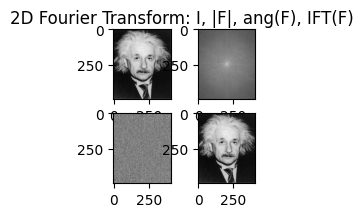

/tmp/ipykernel_1273/2042135095.py:40: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, avgFilter(filterSize))


Images filtered in space and frequency differ in (RMS): 0.0010838837670750028
# images 2
2
3 None None


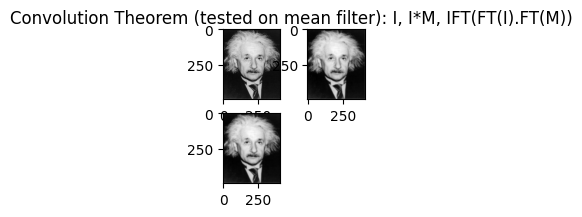

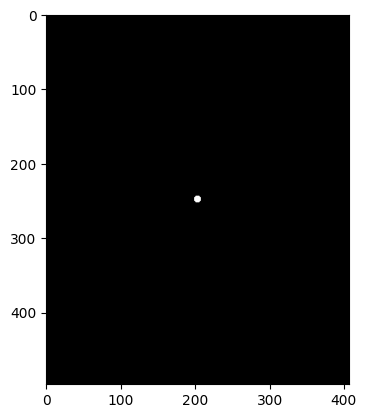

# images 1
1
2 None None


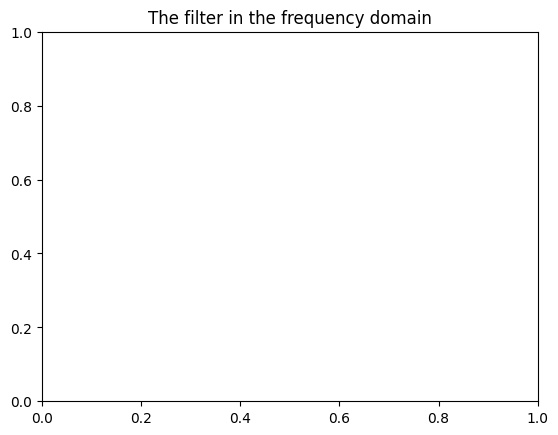

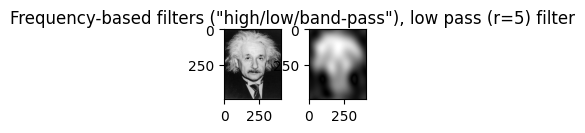

In [31]:
# -----------------
# Test image files
# -----------------
path_input = './imgs-P3/'
path_output = './imgs-out-P3/'
bAllFiles = False
if bAllFiles:
    files = glob.glob(path_input + "*.pgm")
else:
    files = [path_input + 'einstein.jpg']  # lena255, habas, mimbre

# --------------------
# Tests to perform
# --------------------
bAllTests = True
if bAllTests:
    tests = ['testFT', 'testConvTheo', 'testBandPassFilter']
else:
    tests = ['testFT']
    tests = ['testConvTheo']
    tests = ['testBandPassFilter']

# -------------------------------------------------------------------
# Dictionary of user-friendly names for each function ("test") name
# -------------------------------------------------------------------

nameTests = {'testFT': '2D Fourier Transform',
             'testConvTheo': 'Convolution Theorem (tested on mean filter)',
             'testBandPassFilter': 'Frequency-based filters ("high/low/band-pass")'
             }

bSaveResultImgs = False

testsUsingPIL = []  # which test(s) uses PIL images as input (instead of NumPy 2D arrays)


# -----------------------------------------
# Apply defined tests and display results
# -----------------------------------------

def doTests():
    print("Testing on", files)
    for imfile in files:
        im_pil = Image.open(imfile).convert('L')
        im = np.array(im_pil)  # from Image to array

        for test in tests:
            if test is "testFT":
                params = {}
                subTitle = ": I, |F|, ang(F), IFT(F)"
            elif test is "testConvTheo":
                params = {}
                params['filterSize'] = 7
                subTitle = ": I, I*M, IFT(FT(I).FT(M))"
            else:
                params = {}
                r,R = 5,None # for low-pass filter
                # 5,30 for band-pass filter
                # None, 30 for high-pass filter
                params['r'], params['R'] = r,R
                # let's assume r and R are not both None simultaneously
                if r is None:
                    filter="high pass" + " (R=" + str(R) + ")"
                elif R is None:
                    filter="low pass" + " (r=" + str(r) + ")"
                else:
                    filter="band pass" + " (r=" + str(r) + ", R=" + str(R) + ")"
                subTitle = ", " + filter + " filter"

            if test in testsUsingPIL:
                outs_pil = eval(test)(im_pil, params)
                outs_np = vpu.pil2np(outs_pil)
            else:
                # apply test to given image and given parameters
                outs_np = eval(test)(im, params)
            print("# images", len(outs_np))
            print(len(outs_np))

            vpu.showInGrid([im] + outs_np, title=nameTests[test] + subTitle)


if __name__ == "__main__":
    doTests()

In [32]:
# Get files that are images
path_input = './imgs-P3/'
path_output = './imgs-out-P3/'
bAllFiles = False

valid_extensions = ["pgm", "jpg"]

source_images = [
    path for path 
    in glob.glob(path_input + "*.*") 
    if path.split(".")[-1] in valid_extensions
    ]
print(source_images)
source_images = [np.array(Image.open(image).convert('L')) for image in source_images]

['./imgs-P3/einstein.jpg', './imgs-P3/b.pgm', './imgs-P3/a.pgm', './imgs-P3/lena255.pgm', './imgs-P3/mimbre.pgm', './imgs-P3/habas.pgm']


## **Exercice 1**: 
>Given the Fourier Transform of an image, compute 


I will work with the first image

>(a) the lowest and highest magnitude; 


Text(0.5, 1.0, 'Phase')

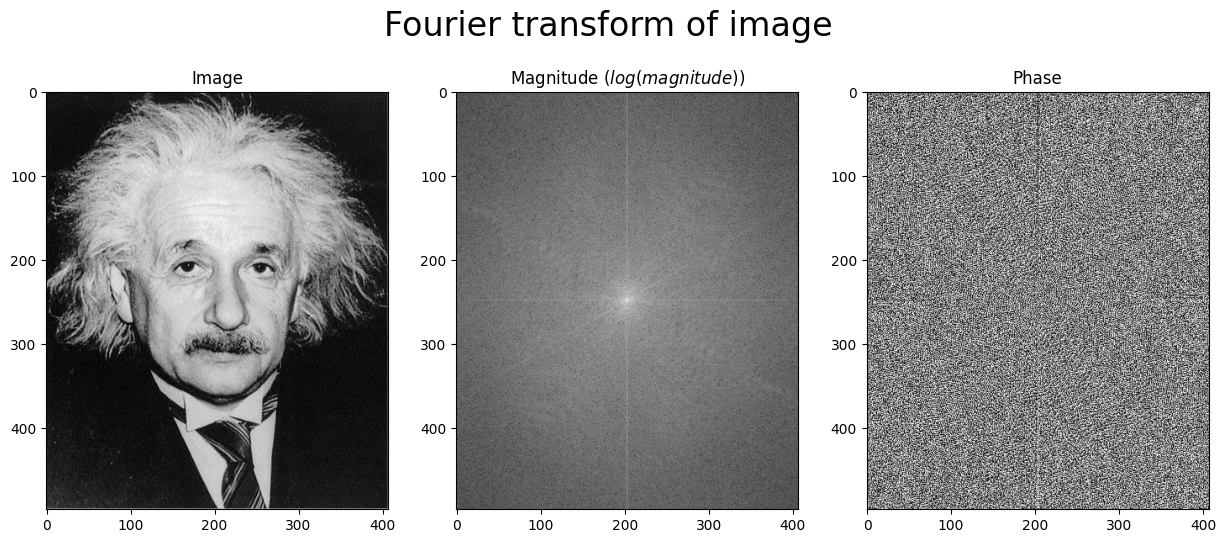

In [218]:
working_image = source_images[0]
magnitude, phase, _ = testFT(working_image)

f, axarr = plt.subplots(1,3, figsize=(15,6))
axarr[0].imshow(working_image)
axarr[1].imshow(magnitude)
axarr[2].imshow(phase)
f.suptitle(f"Fourier transform of image", fontsize=24)
axarr[0].set_title(f"Image")
axarr[1].set_title(f"Magnitude ($log(magnitude)$)")
axarr[2].set_title(f"Phase")


- Min and max amplitude

In [7]:
print(f"Lowest magnitude is {np.min(magnitude)} and highest is {np.max(magnitude)}")

Lowest magnitude is 1.2929587708613193 and highest is 16.781096307101873



>(b) display a boxplot with the magnitude values; 


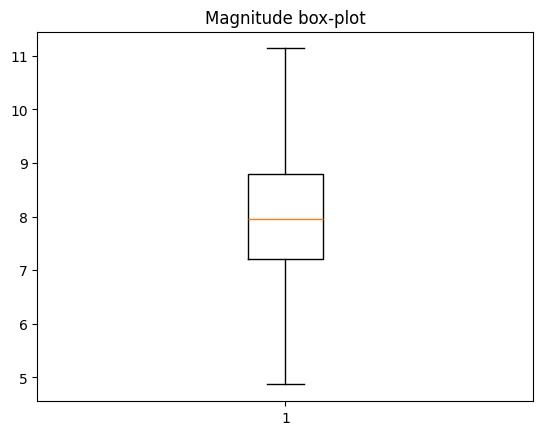

In [9]:
plt.boxplot(magnitude.flatten(), 0, "")
plt.title("Magnitude box-plot")
plt.show()


>(c) plot an histogram of the phase values. To display the boxplot and the histogram, you can use Matplotlib

PHASE: Min = -3.141551943356654; Max = 3.141551943356654


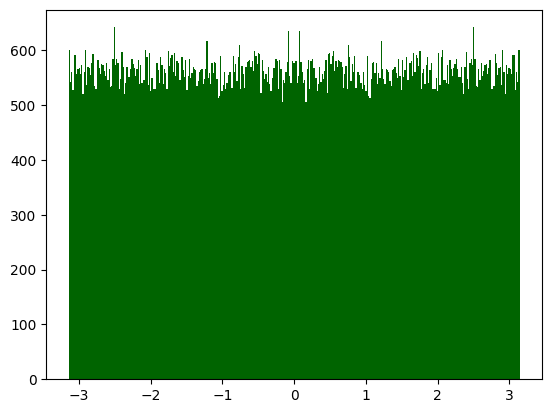

In [75]:
print(f"PHASE: Min = {np.min(phase)}; Max = {np.max(phase)}")

hist = plt.hist(phase.flatten(), 360, color="darkgreen")

## **Exercice 2**: 
>We have seen the convolution theorem applied to the mean filter. Now, apply it to the Gaussian filter and check the result is also as expected. In addition the (filtered) output image, display also the Fourier transform of the filter, and the element-wise product of the Fourier transforms of the image and the filter. Try to figure out the relationship between the size of the mean filter and its Fourier transform. Repeat this analysis on the standard deviation.

The convolution theorem is defined, according to `Wikipedia`, as "*under suitable conditions the Fourier transform of a convolution of two functions (or signals) is the product of their Fourier transforms*, in other workds under suitable conditions the Fourier transform of a convolution of two functions (or signals) is the product of their Fourier transforms.

Which, in this case, means:

**<u>Path A</u>**:

- Making a gaussian kernel
- Applying convoluting image with said kernel

Should give the same result as

**<u>Path B</u>**:

- Performing 2D FFT transform to an image
- Applying THE SAME gaussian kernel to the magnitude of that fft
- Reverting FFT

**1.  Common steps**

Gaussian kernel (1-dimensional)

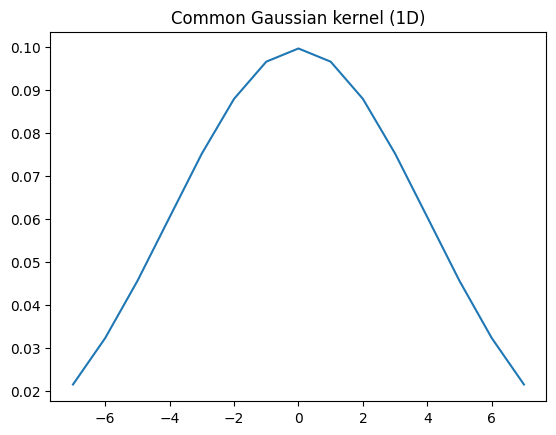

In [227]:
from scipy.stats import norm

# it will be a 9x9 kernel, with standar deviation = 4

x_axis = np.arange(0, 15, 1)
sd = 4
mean = int(np.average(x_axis))
gaussian_kernel = norm.pdf(x_axis, mean, sd)

plt.plot(x_axis -mean, np.array(gaussian_kernel))
plt.title("Common Gaussian kernel (1D)")
plt.show()

Converting it in 2d and normalizing so the sum is 1 when applied

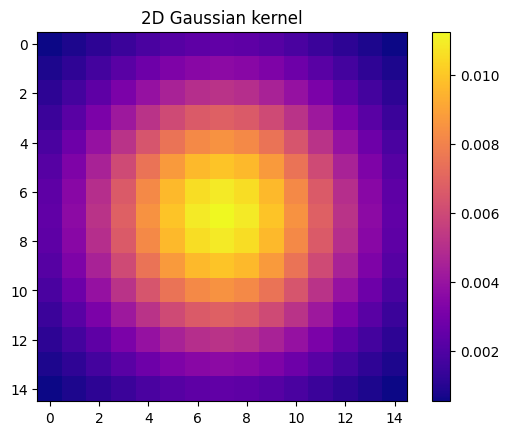

In [228]:
gaussian_kernel_2d = gaussian_kernel.repeat(len(x_axis)).reshape(len(x_axis), len(x_axis))
gaussian_kernel_2d = gaussian_kernel_2d * gaussian_kernel_2d.transpose()
gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)

plt.imshow(gaussian_kernel_2d, cmap="plasma")
plt.colorbar()
plt.title("2D Gaussian kernel")
plt.show()

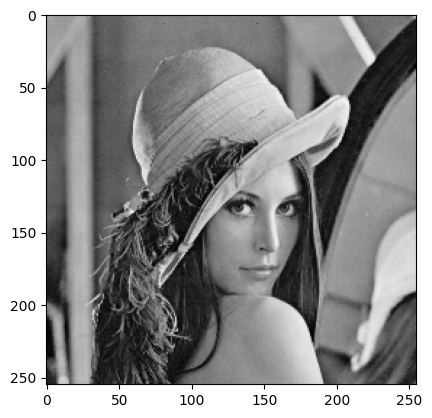

In [229]:
working_image = source_images[1]
plt.imshow(working_image)

**2.** <u>**Path A**</u>

/tmp/ipykernel_229330/1238603283.py:3: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered_pathA = filters.convolve(working_image, gaussian_kernel_2d)


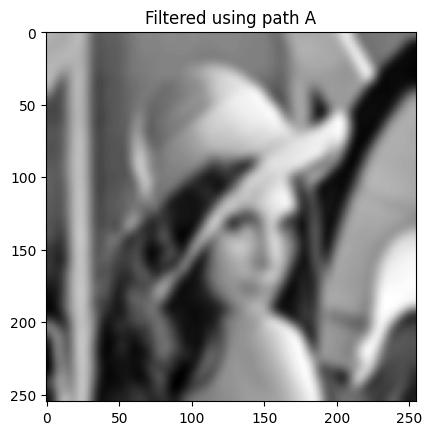

In [230]:
import scipy.ndimage.filters as filters

filtered_pathA = filters.convolve(working_image, gaussian_kernel_2d)

plt.imshow(filtered_pathA)
plt.title("Filtered using path A")
plt.show()

**3.** **<u>Path B</u>**

- Perform fourier analysis on image

Text(0.5, 1.0, 'Phase')

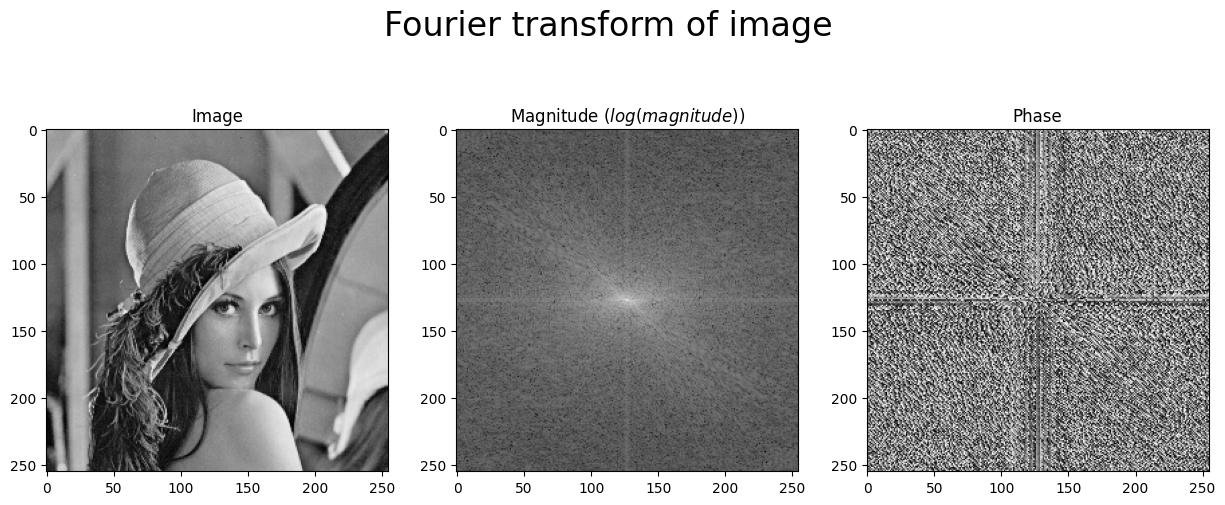

In [236]:
im_ft = fft.fftshift(fft.fft2(working_image))

im_phase = np.angle(im_ft)
im_magnitude = np.abs(im_ft)

f, axarr = plt.subplots(1,3, figsize=(15,6))
axarr[0].imshow(working_image)
axarr[1].imshow(np.log(im_magnitude))
axarr[2].imshow(im_phase)
f.suptitle(f"Fourier transform of image", fontsize=24)
axarr[0].set_title(f"Image")
axarr[1].set_title(f"Magnitude ($log(magnitude)$)")
axarr[2].set_title(f"Phase")

- Fourier transform of gaussian

120 120
[[0.00031873 0.00030758 0.00028565 ... 0.00028565 0.00030758 0.00031873]
 [0.00030758 0.00029681 0.00027566 ... 0.00027566 0.00029681 0.00030758]
 [0.00028565 0.00027566 0.00025601 ... 0.00025601 0.00027566 0.00028565]
 ...
 [0.00028565 0.00027566 0.00025601 ... 0.00025601 0.00027566 0.00028565]
 [0.00030758 0.00029681 0.00027566 ... 0.00027566 0.00029681 0.00030758]
 [0.00031873 0.00030758 0.00028565 ... 0.00028565 0.00030758 0.00031873]]


Text(0.5, 1.0, 'Fourier of Kernel')

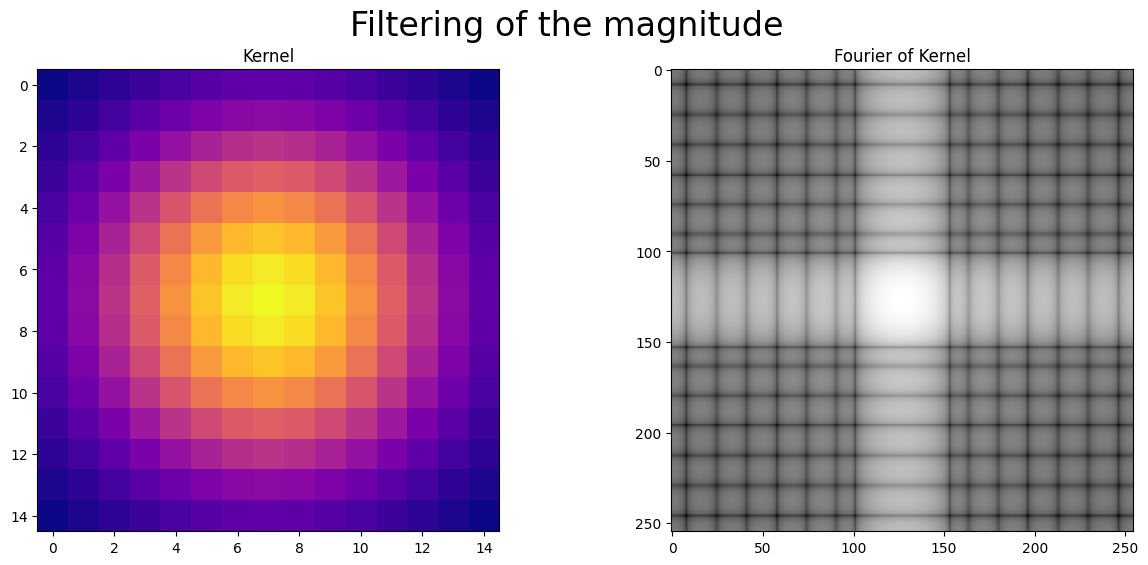

In [238]:
gaussian_centered_on_image_size = np.zeros_like(working_image).astype(float)
(h_start, w_start) = (np.array(im_magnitude.shape)//2 - np.array(gaussian_kernel_2d.shape)//2)
print(h_start, w_start)
gaussian_centered_on_image_size[h_start: h_start+gaussian_kernel_2d.shape[0], w_start: w_start+gaussian_kernel_2d.shape[1]] = gaussian_kernel_2d
gaussian_kernel2D_ft =fft.fftshift(fft.fft2(gaussian_centered_on_image_size))

g_phase = np.angle(gaussian_kernel2D_ft)
g_magnitude = np.abs(gaussian_kernel2D_ft)
print(g_magnitude)

f, axarr = plt.subplots(1,2, figsize=(15,6))
axarr[0].imshow(gaussian_kernel_2d, cmap="plasma")
axarr[1].imshow(np.log(g_magnitude))
f.suptitle(f"Filtering of the magnitude", fontsize=24)
axarr[0].set_title("Kernel")
axarr[1].set_title("Fourier of Kernel")

- Multiply magnitudes

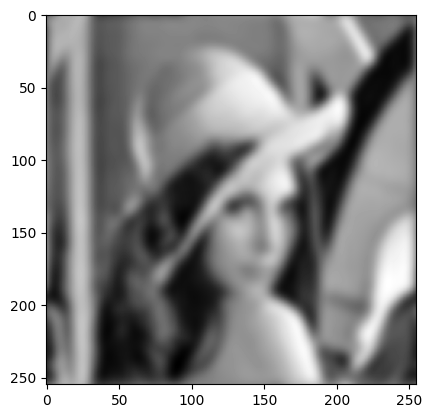

In [240]:
im_magnitude_filtered = im_magnitude * g_magnitude

F_filtered = im_magnitude_filtered * np.exp(1j * im_phase)
image_pathB = np.real(fft.ifft2(fft.ifftshift(F_filtered)))

plt.imshow(image_pathB)

**4. Comparing results**

212 48 213.0514626144106 48.609141533637036


Text(0.5, 1.0, 'Difference (normalized)')

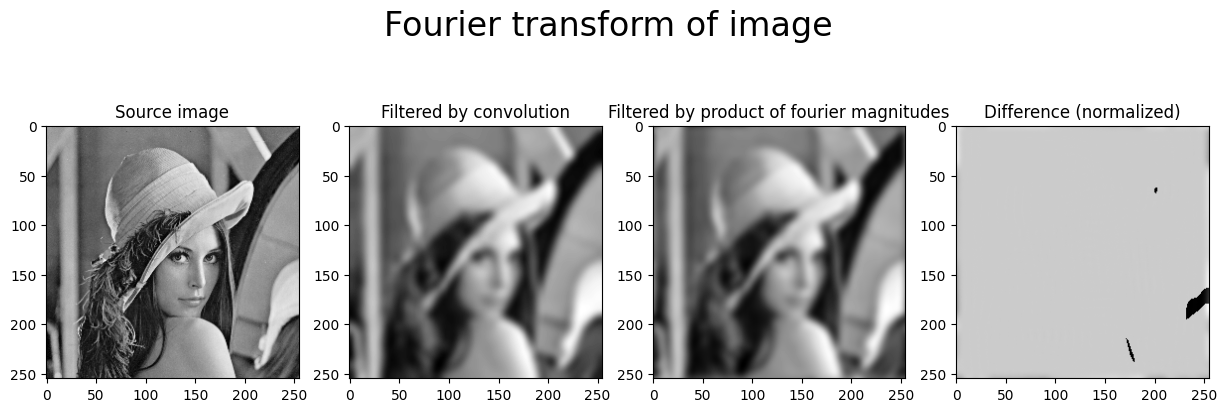

In [241]:
f, axarr = plt.subplots(1,4, figsize=(15,5))
axarr[0].imshow(working_image)
axarr[1].imshow(filtered_pathA)
axarr[2].imshow(image_pathB)
Amin, Amax = np.min(filtered_pathA), np.max(filtered_pathA)
Bmin, Bmax = np.min(image_pathB), np.max(image_pathB)
print(Amax, Amin, Bmax, Bmin)
axarr[3].imshow((filtered_pathA+Amin)/(Amax-Amin)  - (image_pathB+Bmin)/(Bmax-Bmin))
f.suptitle(f"Fourier transform of image", fontsize=24)
axarr[0].set_title(f"Source image")
axarr[1].set_title(f"Filtered by convolution")
axarr[2].set_title(f"Filtered by product of fourier magnitudes")
axarr[3].set_title("Difference (normalized)")

Except for the borders, we can see that the difference between the images give a somewhat flat matrix (except for some reigions) <mark style="background-color:red; color:white">Ask</mark>

## **Exercice 3**: 
>A practical implication of the convolution theorem is the computational saving it may offer by performing computations in the frequency domain instead of in the spatial domain. Carry out a study of the running times for differnt sizes of the mask filter, and for different image sizes. Display a plot of the measured times (mean and deviation) to appreciate  the influence of the image size for a given mask size, and another plot where the image size is fixed and the mask size is varied. Observe the results carefully, and comment on them.

In [247]:
import time

In [290]:
sigma_list = np.array(np.linspace(0.5, 15, 30)) # odd numbers from 0 to N
sigma_list

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ])

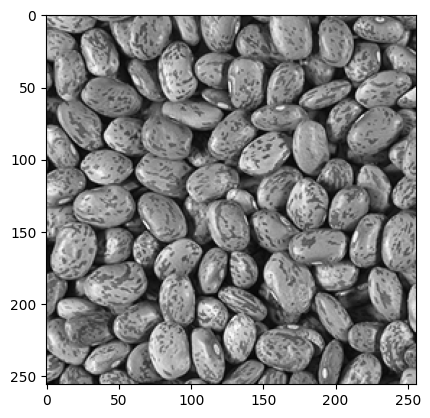

In [251]:
working_image = source_images[5]
plt.imshow(working_image)

Filter with gaussian kernel:

In [296]:
def gaussianFilterManual_processTime(im, sigma=5):
    s_time = time.time()
    window_size = int(round(4.0 * sigma))
    x_axis = np.arange(0, window_size, 1)
    mean = window_size//2
    gv2d = norm.pdf(x_axis, mean, sigma).repeat(window_size).reshape(window_size, window_size)
    gv2d = gv2d * gv2d.transpose()
    gv2d = gv2d/np.sum(gv2d)
    filters.convolve(im, gv2d)
    return time.time() - s_time

listTimes_gaussian = [gaussianFilterManual_processTime(working_image, sigma) for sigma in sigma_list]
print(listTimes_gaussian)

/tmp/ipykernel_229330/141787085.py:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filters.convolve(im, gv2d)


[0.0025725364685058594, 0.0018587112426757812, 0.0034449100494384766, 0.0041429996490478516, 0.004967689514160156, 0.006239175796508789, 0.008238077163696289, 0.010554075241088867, 0.013044595718383789, 0.015400886535644531, 0.01961374282836914, 0.023578166961669922, 0.026734352111816406, 0.03145194053649902, 0.03641462326049805, 0.04201793670654297, 30.30724263191223, -30.412095546722412, 0.05781745910644531, 0.0637211799621582, 0.07123851776123047, 0.08517742156982422, 0.10594463348388672, 0.1056818962097168, 0.1225121021270752, 0.14037251472473145, 0.15686392784118652, 0.172072172164917, 0.17464518547058105, 0.19242548942565918]


Filter with product of fourier magnitudes:

In [297]:
def gaussianFilterFouriers_processTime(im, sigma=5):
    s_time = time.time()
    window_size = int(round(4.0 * sigma))
    x_axis = np.arange(0, window_size, 1)
    mean = window_size//2
    gv2d = norm.pdf(x_axis, mean, sigma).repeat(window_size).reshape(window_size, window_size)
    gv2d = gv2d * gv2d.transpose()
    gv2d = gv2d/np.sum(gv2d)


    im_ft = fft.fftshift(fft.fft2(im))

    im_phase = np.angle(im_ft)
    im_magnitude = np.abs(im_ft)

    gvd_centered = np.zeros_like(working_image)
    (h_start, w_start) = (np.array(im_magnitude.shape)//2 - np.array(gv2d.shape)//2)
    gvd_centered[h_start: h_start+gv2d.shape[0], w_start: w_start+gv2d.shape[1]] = gv2d
    
    gv2d_ft =fft.fftshift(fft.fft2(gvd_centered))

    g_magnitude = np.abs(gv2d_ft)

    im_magnitude_filtered = im_magnitude * g_magnitude

    F_filtered = im_magnitude_filtered * np.exp(1j * im_phase)
    np.real(fft.ifft2(fft.ifftshift(F_filtered)))

    return time.time() - s_time

listTimes_fourier = [gaussianFilterFouriers_processTime(working_image, sigma) for sigma in sigma_list]
print(listTimes_fourier)

[0.008874177932739258, 0.006424427032470703, 0.007730245590209961, 0.006444692611694336, 0.006376743316650391, 0.006821393966674805, 0.0064182281494140625, 0.006918907165527344, 0.007238864898681641, 0.006409168243408203, 0.006108522415161133, 0.005910396575927734, 0.005427122116088867, 0.005723714828491211, 0.0062181949615478516, 0.005634784698486328, 0.005591154098510742, 0.0061986446380615234, 0.00553131103515625, 0.0058155059814453125, 0.0056040287017822266, 0.005308866500854492, 0.0055196285247802734, 0.005426645278930664, 0.00531768798828125, 0.00542902946472168, 0.0057260990142822266, 0.005578517913818359, 0.005583047866821289, 0.0056896209716796875]


Compare:

[0.0025725364685058594, 0.0018587112426757812, 0.0034449100494384766, 0.0041429996490478516, 0.004967689514160156, 0.006239175796508789, 0.008238077163696289, 0.010554075241088867, 0.013044595718383789, 0.015400886535644531, 0.01961374282836914, 0.023578166961669922, 0.026734352111816406, 0.03145194053649902, 0.03641462326049805, 0.04201793670654297, 30.30724263191223, -30.412095546722412, 0.05781745910644531, 0.0637211799621582, 0.07123851776123047, 0.08517742156982422, 0.10594463348388672, 0.1056818962097168, 0.1225121021270752, 0.14037251472473145, 0.15686392784118652, 0.172072172164917, 0.17464518547058105, 0.19242548942565918]


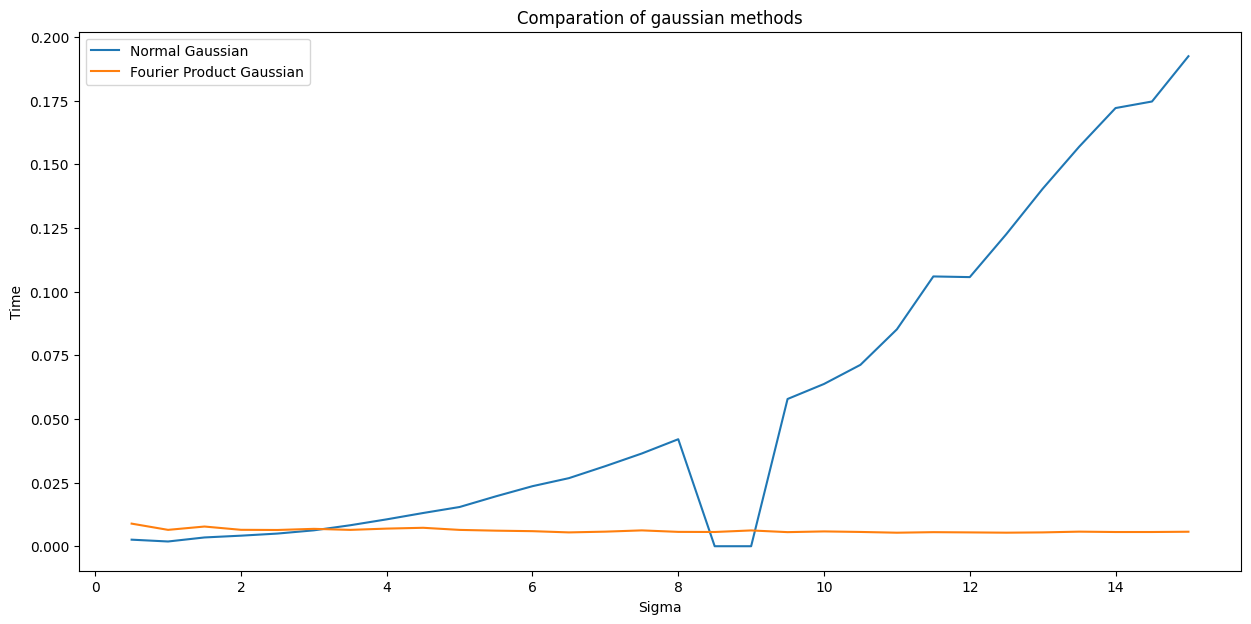

In [298]:
print(listTimes_gaussian)
listTimes_gaussian = [item if abs(item) < 5 else 0 for item in listTimes_gaussian] # remove outliers (other processes in my system)

plt.figure(figsize=(15,7))
plt.plot(sigma_list, listTimes_gaussian, label="Normal Gaussian")
plt.plot(sigma_list, listTimes_fourier, label="Fourier Product Gaussian")
plt.xlabel("Sigma")
plt.ylabel("Time")
plt.legend()
plt.title("Comparation of gaussian methods")
plt.show()

## **Exercice 4**: 
> Write `my_mask(n)` without the explicit loops that returns a 2D array of size $n·n$ following this pattern:
>
>$$
>M_{n=3} =
\begin{bmatrix}
    0 & -1 & -1 \\
    1 & 0 & -1 \\
    1 & 1 & 0
\end{bmatrix}
M_{n=4} =
\begin{bmatrix}
    0 & -1 & -1 & -1 \\
    1 & 0 & -1 & -1 \\
    1 & 1 & 0 & -1 \\
    1 & 1 & 1 & 0
\end{bmatrix}
>$$
>
>Then write `my_filter(im, n)` to use the output of `my_mask(n)` as a mask to filter the image `im` in the frequency domain
    


- Writing `my_mask(n)`:

In [33]:
def my_mask(n:int):
    mat = np.zeros((n, n))
    mat[np.tril_indices(n, k=1)] = 1
    mat[np.triu_indices(n, k=1)] = -1
    mat[np.diag_indices(n)] = 0
    return mat

- Writing `my_filter(im, n)`

In [63]:
def my_filter(im: np.ndarray, n: int):
    ft = FT(im)

    ft_magnitude = np.absolute(ft)
    ft_phase = np.angle(ft)

    kernel = my_mask(n)

    kernel_centered = np.zeros_like(ft_magnitude)
    (h_start, w_start) = (np.array(ft_magnitude.shape)//2 - np.array(kernel.shape)//2)
    kernel_centered[h_start: h_start+kernel.shape[0], w_start: w_start+kernel.shape[1]] = kernel

    kft = FT(kernel_centered)

    k_magnitude = np.absolute(kft)

    ft_magnitude_filt = ft_magnitude * k_magnitude

    im_filtered = ft_magnitude_filt * np.exp(1j * ft_phase)
    return np.real(fft.ifft2(fft.ifftshift(im_filtered))), [ft_magnitude, ft_magnitude_filt, kernel]

Trying on image:

/tmp/ipykernel_1273/1985736798.py:11: RuntimeWarning: divide by zero encountered in log
  axarr[3].imshow(np.log(extras[1]))


Text(0.5, 1.0, 'Kernel')

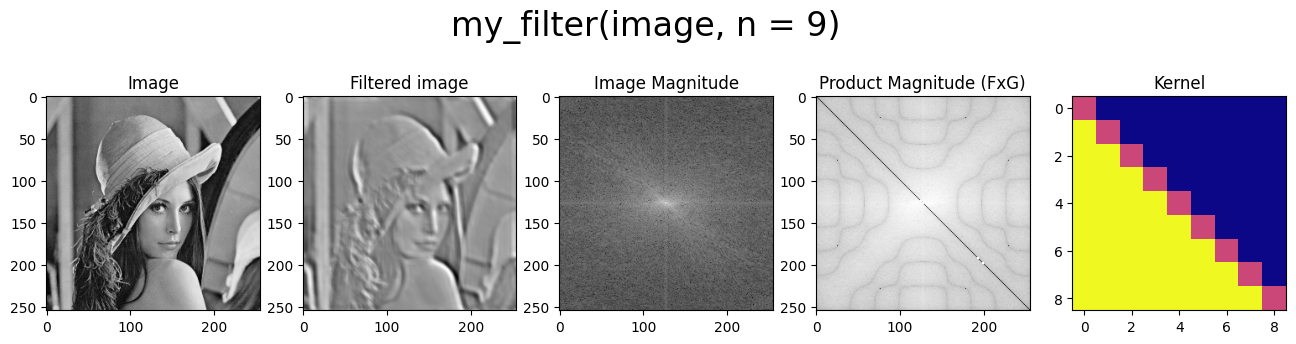

In [75]:
working_image = source_images[1]
n = 9

filtered, extras = my_filter(working_image, n)
# (_filtered, _im_mag, _filt_mag, _kernel)

f, axarr = plt.subplots(1,5, figsize=(16,4))
axarr[0].imshow(working_image)
axarr[1].imshow(filtered)
axarr[2].imshow(np.log(extras[0]))
axarr[3].imshow(np.log(extras[1]))
axarr[4].imshow(extras[2], cmap="plasma")
f.suptitle(f"my_filter(image, n = {n})", fontsize=24)
axarr[0].set_title(f"Image")
axarr[1].set_title(f"Filtered image")
axarr[2].set_title(f"Image Magnitude")
axarr[3].set_title(f"Product Magnitude (FxG)")
axarr[4].set_title(f"Kernel")

## **Exercice 5**: 
>Get the Fourier transform of stp1.gif and stp2.gif. Let $F1$ and $F2$ be these transforms. Compute and observe the inverse transform of their combination: $$λ·F1 +(1 − λ) · F2,λ∈[0,1]$$ What property of the $FT$ does this result illustrate? 

## **Exercice 6**: 
>The  frequency  filters  we  have  seen  set  to  all  (1)  or  nothing (0) so that the desired frequency ranges (either high, low or band) are selected or removed, with abrupt changes. Write smoothed versions of the filters so that transition between 0 to 1 is somehow smooth. For the same values of $r$ and $R$, ompare the abrupt and smooth filters  and  comment  on  the  possible  influence on  the result.
